In [251]:
import transformers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import speech_recognition as sr

In [252]:
df = pd.read_csv("labeled_data.csv")

In [253]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


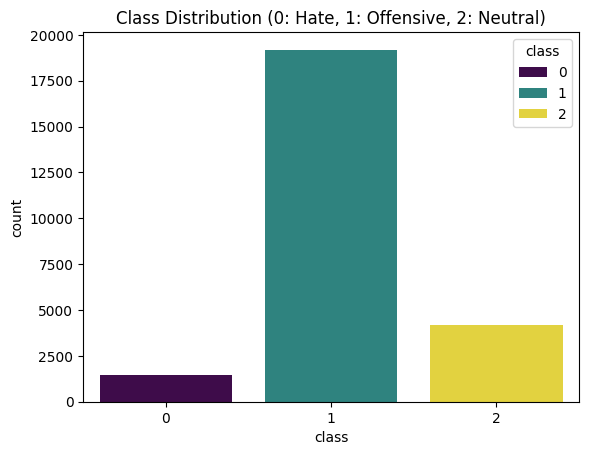

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [254]:
import seaborn as sns

sns.countplot(x='class', hue = 'class', palette='viridis', data=df)
plt.title("Class Distribution (0: Hate, 1: Offensive, 2: Neutral)")
plt.show()

df['class'].value_counts()

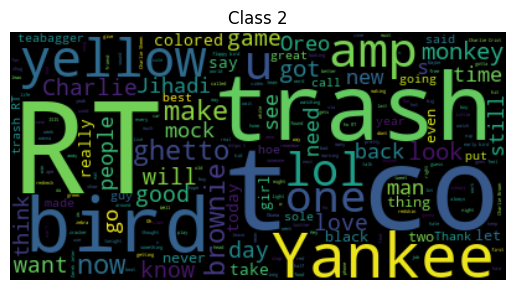

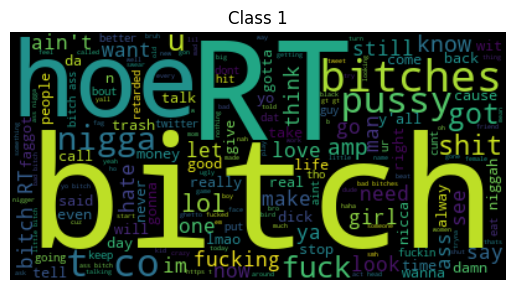

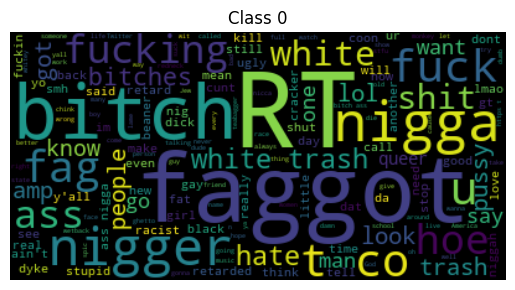

In [255]:
from wordcloud import WordCloud

for c in df['class'].unique():
    text = " ".join(df[df['class'] == c]['tweet']) # Join all tweets into a single large string separated by spaces to create one big blob of text
    wc = WordCloud().generate(text)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Class {c}")
    plt.show()

In [257]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#", "", text)  # remove URLs, mentions, hashtags
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\d+", "", text)      # remove digits
    return text.strip()

df['tweet'] = df['tweet'].apply(preprocess_text)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about cle...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat h...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she sta...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true o...


In [258]:
sample = df['tweet'][5]
print(sample)

the shit just blows meclaim you so faithful and down for somebody but still fucking with hoes


In [259]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2)) # ngrams to capture phrases and context (unigram = 1 and bigram =2)

X = tfidf.fit_transform(df['tweet'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression

In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model1 = LogisticRegression(max_iter=1000, class_weight="balanced")
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)

print(f"Logistic Regression Accuracy: {acc1}")
print(f"Classification Report:\n{classification_report(y_test, y_pred1)}")

Logistic Regression Accuracy: 0.8517248335686908
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.60      0.41       286
           1       0.97      0.85      0.91      3838
           2       0.77      0.94      0.84       833

    accuracy                           0.85      4957
   macro avg       0.68      0.80      0.72      4957
weighted avg       0.90      0.85      0.87      4957



# Random Forest Classifier

In [262]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
acc2 = accuracy_score(y_test, y_pred2)

print(f"Random Forest Accuracy: {acc2}")
print(f"Classification Report:\n{classification_report(y_test, y_pred2)}")

Random Forest Accuracy: 0.9001412144442204
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.21      0.30       286
           1       0.93      0.95      0.94      3838
           2       0.82      0.92      0.87       833

    accuracy                           0.90      4957
   macro avg       0.75      0.69      0.70      4957
weighted avg       0.89      0.90      0.89      4957



# Hate Speech Detection Using Random Forest Model

In [263]:
labelMap = {0: "Hate Speech", 1: "Offensive", 2: "Neither"}

def predict_tweet(text):
    text = prep_text(text)
    vec = tfidf.transform([text])
    pred = model2.predict(vec)[0]
    return labelMap[pred]

print(f"Tweet: {sample} : Prediction = {predict_tweet(sample)}")

txt = "I love this random forest model!"
print(f"Tweet: {txt} : Prediction = {predict_tweet(txt)}")

Tweet: the shit just blows meclaim you so faithful and down for somebody but still fucking with hoes : Prediction = Offensive
Tweet: I love this random forest model! : Prediction = Neither


# Transformers based implementation (RoBERTa) for Unlabeled Data

In [264]:
df1 = pd.read_csv("labeled_data.csv")
df1 = df1.drop(["hate_speech", "Unnamed: 0", "count", "offensive_language", "neither", "class"], axis =1)

In [265]:
df1.head()

,tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [266]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [267]:
labelMap = {'LABEL_0': 'Hate Speech', 'LABEL_1': 'Offensive', 'LABEL_2': 'Neither'}

check = df1['tweet'][5]
print(check)

!!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"


In [268]:
model3 = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
sentiment_pipeline = pipeline("sentiment-analysis", model=model3, tokenizer=tokenizer)

Device set to use cpu


In [269]:
result = sentiment_pipeline(check)
result[0]['label'] = labelMap[result[0]['label']]
print(result)

[{'label': 'Hate Speech', 'score': 0.9725279808044434}]
